<div align='left' style="width:400px;height:120px;overflow:hidden;">
<a href='http://www.uff.br'>
<img align='left' style='display: block;height: 92%' src='imgs/UFF.png' alt='UFF logo' title='UFF logo'/>
</a>
<a href='http://www.ic.uff.br'>
<img align='left' style='display: block;height: 100%' src='imgs/logo-ic.png' alt='IC logo' title='IC logo'/>
</a>
</div>

### Machine Learning
# Learning, Validation and Meta Learning

### [Luis Martí](http://lmarti.com)
#### [Instituto de Computação](http://www.ic.uff)
#### [Universidade Federal Fluminense](http://www.uff.br)
$\newcommand{\vec}[1]{\boldsymbol{#1}}$

In [1]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn; seaborn.set_style('whitegrid')
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import random, itertools
random.seed(a=42)

from IPython.display import display, HTML, Image

## Question 1

* What is the difference between **bias** and **variance**?
* How do ensemble methods help?

## Answer 1

We vary the **training set** and (hypothetically) observe the **true error**.

### Bias vs. Variance

Source: [Understanding the Bias-Variance Tradeoff (Scott Fortmann-Roe)](http://scott.fortmann-roe.com/docs/BiasVariance.html)

In [5]:
def plot_target():
    t = np.linspace(0, 2*np.pi, 100); 
    plt.plot(np.cos(t), np.sin(t)); 
    plt.plot(0.67*np.cos(t), 0.67*np.sin(t))
    plt.plot(0.33*np.cos(t), 0.33*np.sin(t))
    plt.scatter(0, 0, color="black")

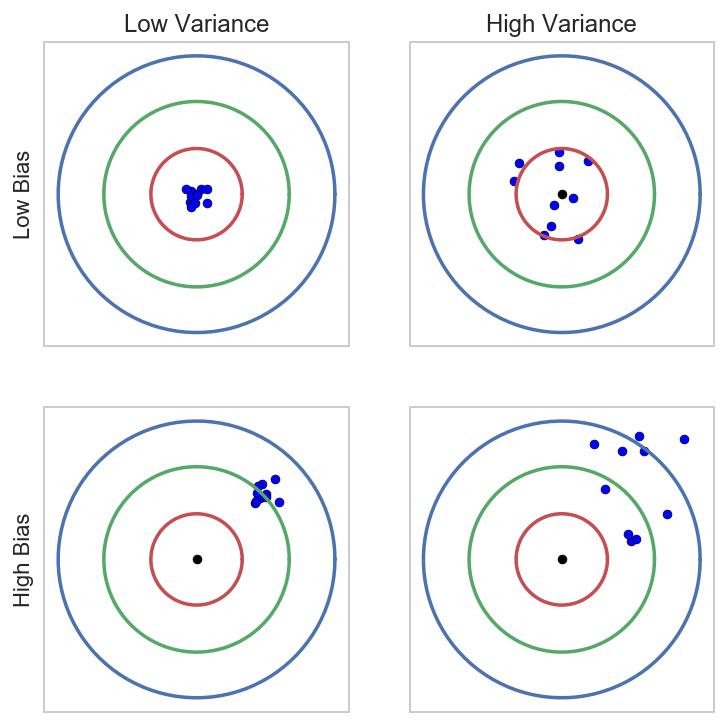

In [7]:
plt.figure(figsize=(6, 6))
plt.setp(plt.subplot(2, 2, 1), xticks=(), yticks=())
plot_target()
plt.title("Low Variance"); plt.ylabel("Low Bias")
plt.scatter((np.random.rand(10)-0.5)*0.2, (np.random.rand(10)-0.5)*0.2)
plt.setp(plt.subplot(2, 2, 2), xticks=(), yticks=())
plot_target()
plt.title("High Variance")
plt.scatter((np.random.rand(10)-0.5)*0.8, (np.random.rand(10)-0.5)*0.8)
plt.setp(plt.subplot(2, 2, 3), xticks=(), yticks=())
plot_target()
plt.ylabel("High Bias")
plt.scatter((np.random.rand(10)-0.5)*0.2+0.5, (np.random.rand(10)-0.5)*0.2+0.5)
plt.setp(plt.subplot(2, 2, 4), xticks=(), yticks=())
plot_target()
plt.scatter((np.random.rand(10)-0.5)*0.8+0.5, (np.random.rand(10)-0.5)*0.8+0.5)

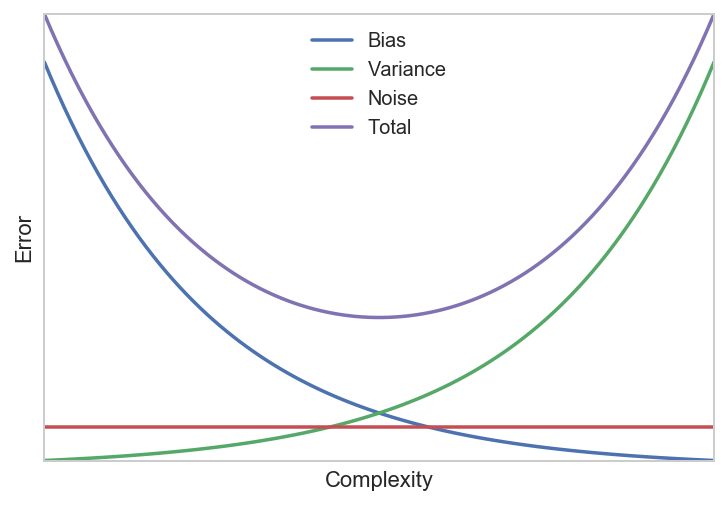

In [9]:
plt.setp(plt.gca(), xticks=(), yticks=(), xlabel="Complexity", ylabel="Error")
resolution = 100
complexity = np.linspace(0, 4, resolution)
noise_error = np.ones(resolution) * 0.1
bias_error = np.exp(-complexity)
variance_error = np.exp(complexity - np.max(complexity))
plt.plot(complexity, bias_error, label="Bias")
plt.plot(complexity, variance_error, label="Variance")
plt.plot(complexity, noise_error, label="Noise")
plt.plot(complexity, bias_error + variance_error + noise_error, label="Total")
plt.legend(loc="best")

### Examples

**Example for Bias**

* We use a linear model to approximate a nonlinear function.
* We use a decision stump to approximate function that requires a hierarchy.
* We use a polynomial of degree 3 to approximate a polynomial of degree 10.
* **In general:** we use a simple model to approximate a more complex function.

**Example for Variance**

* We use gradient descent to optimize a non-convex error function of a model (with many local minima).
* We use an SVM with RBF kernel and $C \rightarrow \infty$ and a small dataset.
* **In general:** we use a complex model that is likely to overfit and learn the noise of the training set.

# Meta Learning for Regression

## Base Learner: Multilayer Neural Network

* is a universal function approximator
* can be used for classification **and** regression

To run this example you have to install the library [OpenANN](https://github.com/OpenANN/OpenANN).

In [2]:
from openann import *

class NeuralNetwork(object):
    """Wrapper around OpenANN library."""
    def __init__(self, n_nodes):
        self.n_nodes = n_nodes
    def fit(self, X, y):
        Y = y[:, newaxis]
        self.net = Net().input_layer(X.shape[1]) \
                        .fully_connected_layer(self.n_nodes, Activation.TANH) \
                        .output_layer(1, Activation.LINEAR)
        dataset = DataSet(X, Y)
        optimizer = LMA({"maximal_iterations" : 50})
        optimizer.optimize(self.net, dataset)
    def predict(self, X):
        return self.net.predict(X)[:, 0]

ImportError: No module named 'openann'

## Meta Learner: Bagging

* each base learner is trained on a **different subset** (generated by sampling **with** replacement) of the training set
* predictions will be made based on **majority voting**
* Bagging requires unstable learners (high variance error) to build a single stable model (low variance error)
* usually combines models of the same type

In this example we will **average predictions** are over all base learners!

In [5]:
class Bagging(object):
    def __init__(self, models, bag_size):
        assert bag_size > 0.0 and bag_size < 1.0
        self.models = models
        self.bag_size = bag_size
    def fit(self, X, y):
        N = X.shape[0]
        for model in self.models:
            bag_indices = random.randint(0, N, int(N*self.bag_size))
            model.fit(X[bag_indices], y[bag_indices])
    def predict(self, X):
        return mean([m.predict(X) for m in self.models], axis=0)

## Data Set

Sine function with normally distributed noise.

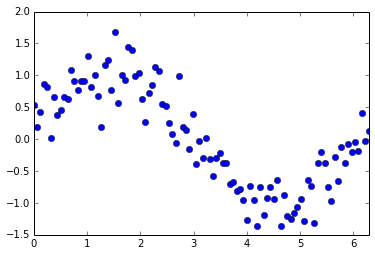

In [6]:
random.seed(0)
N = 100
X = linspace(0, 2*pi, N)[:, newaxis]
y = array(sin(X[:, 0]) + random.randn(N) * 0.3)

plot(X, y, "o")
r = xlim(0, 2*pi)

In [7]:
def eval_bagging(X, y, n_models=50, bag_size=0.2, n_nodes=10):
    models = [NeuralNetwork(n_nodes) for _ in xrange(n_models)]
    bagging = Bagging(models, bag_size)
    bagging.fit(X, y)
    h = bagging.predict(X)
    p = [m.predict(X) for m in models]
    p_err = [abs(pn-y) for pn in p]
    h_err = abs(h-y)
    return p, h, p_err, h_err

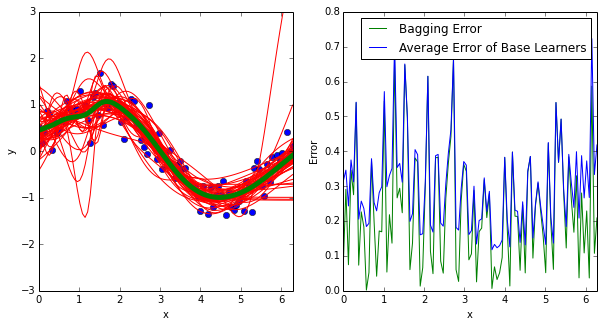

In [8]:
random.seed(0)
RandomNumberGenerator().seed(0)

p, h, p_err, h_err = eval_bagging(X, y)

figure(figsize=(10, 5))
# Plot dataset and model(s)
setp(subplot(1, 2, 1), xlabel="x", ylabel="y", xlim=(0, 2*pi), ylim=(-3, 3))
plot(X, y, "o")
for pn in p: plot(X, pn, "r-")
plot(X, h, "-", linewidth=5)
# Plot errors
setp(subplot(1, 2, 2), xlabel="x", ylabel="Error", xlim=(0, 2*pi))
plot(X, h_err, "g", label="Bagging Error")
plot(X, mean(p_err, axis=0), "b", label="Average Error of Base Learners")
l = legend(loc="best")

## Question 2

* What are the differences between Bagging and AdaBoost?

# AdaBoost

* assigns a weight for each model
* requires learners of the same type
* each base learner is an **expert** for a part of the training set

(There is another interesting type of boosting: [Human Boosting](http://www.cs.utexas.edu/~pradeepr/paperz/humanboosting.pdf))

## AdaBoost Algorithm

* training loop
    * train weak classifier
    * assign a weight according to its error on the training set
    * reweight dataset to encourage the next classifier to become an expert for the part of the training set that has been classified wrong
* prediction
    * weighted average of predictions of the weak classifiers

## Example: AdaBoost with Neural Nets

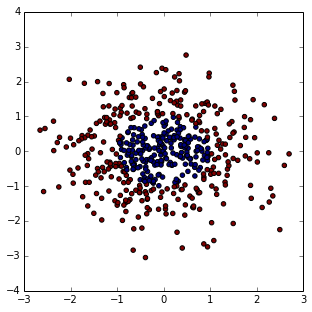

In [9]:
n_samples = 500

random.seed(0)

X = random.randn(n_samples, 2)
y = array([linalg.norm(x) > 1.0 for x in X], dtype=float64)
T = y[:, newaxis]

figure(figsize=(5, 5))
r = scatter(X[:, 0], X[:, 1], c=y)

To run this example [OpenANN](https://github.com/OpenANN/OpenANN) is required.

In [10]:
n_models = 5

from openann import *
from util import plot_classifier

# Train ensemble
RandomNumberGenerator().seed(0)
adaboost = AdaBoost()
nets = [Net().input_layer(2)
             .fully_connected_layer(2, Activation.LOGISTIC)
             .output_layer(1, Activation.LOGISTIC)
        for _ in xrange(n_models)]
for net in nets: adaboost.add_learner(net)
opt = LMA(stop={"maximal_iterations" : 10})
adaboost.set_optimizer(opt)
dataset = DataSet(X, T)
adaboost.train(dataset)
weights = adaboost.get_weights()

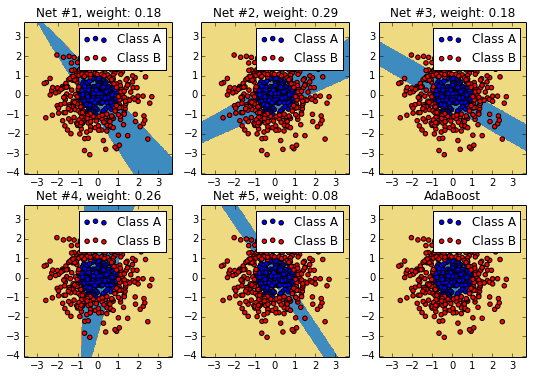

In [11]:
figure(figsize=(9, 6))
n_rows, n_cols = (2, 3)
for m in xrange(n_models):
    subplot(n_rows, n_cols, 1+m)
    plot_classifier(X, y, nets[m], "Net #%d, weight: %.2f" % (m+1, weights[m]), threshold=0.5)
subplot(n_rows, n_cols, n_models+1)
plot_classifier(X, y, adaboost, "AdaBoost", threshold=0.5)

## Example: AdaBoost with Decision Stumps

[Source](http://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_twoclass.html)